## Credit Card Fraud Detection Predictive Models

#### Credit card companies need to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. 

Due to confidentiality issues, these are not provide the original features and more background information about the data. 

1. Features V1, V2, … V28 are the principal components obtained with PCA.

2. The only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning.

3. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

![ChessUrl](https://media.giphy.com/media/hcNiEhcQd1Aomwa9qp/giphy.gif "chess")

### Loading the Packages

In [161]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from math import *
import os
import seaborn as sns 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime 
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
CV_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

### Reading the Data

In [2]:
credit_card_data = pd.read_csv('creditcard.csv')

### Checking the Data

In [3]:
credit_card_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
credit_card_data.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   

        V15       V16       V17       V18       V19       V20       V21  \
0  1.468177 -0.470401  0.207971  0.025791  0.403993  0.251412 -0.018307   
1  0.635558  0.463917 -0.114805 -0.183361 -0.145783 -0.069083 -0.225775   
2  2.345865 -2.890083  1.109969 -0.121359 -2.261857  0.524980  0.247998   
3 -0.631418 -1.059647 -0.684093  1.965775 -1.232622 -0.208038 -0.108300   
4  0.175121 -0.451449 -0.237033 -0.038195  0.803487  0.408542 -0.009431   

        V22       V23       V24       V25       V26       V27       V28  \
0  0.277838 -0.110474  0.066928  0.128539 -0.189115  0.133558 -0.021053   
1 -0.638672  0.101288 -0.339846  0.167170  0.125895 -0.008983  0.014724   
2  0.771679  0.909412 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752   
3  0.005274 -0.190321 -1.175575  0.647376 -0.221929  0.062723  0.061458   
4  0.798278 -0.137458  0.141267 -0.206010  0.502292  0.219422  0.215153   

   Amount  Class  
0  149.62      0  
1    2.69      0  
2  378.66      0  
3  123.50      0  
4   69.99      0

In [5]:
credit_card_data.describe()

Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  3.918649e-15  5.682686e-16 -8.761736e-15  2.811118e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean  -1.552103e-15  2.040130e-15 -1.698953e-15 -1.893285e-16 -3.147640e-15   
std    1.380247e+00  1.332271e+00  1.237094e+00  1.194353e+00  1.098632e+00   
min   -1.137433e+02 -2.616051e+01 -4.355724e+01 -7.321672e+01 -1.343407e+01   
25%   -6.915971e-01 -7.682956e-01 -5.540759e-01 -2.086297e-01 -6.430976e-01   
50%   -5.433583e-02 -2.741871e-01  4.010308e-02  2.235804e-02 -5.142873e-02   
75%    6.119264e-01  3.985649e-01  5.704361e-01  3.273459e-01  5.971390e-01   
max    3.480167e+01  7.330163e+01  1.205895e+02  2.000721e+01  1.559499e+01   

                V10           V11           V12           V13           V14  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   1.772925e-15  9.289524e-16 -1.803266e-15  1.674888e-15  1.475621e-15   
std    1.088850e+00  1.020713e+00  9.992014e-01  9.952742e-01  9.585956e-01   
min   -2.458826e+01 -4.797473e+00 -1.868371e+01 -5.791881e+00 -1.921433e+01   
25%   -5.354257e-01 -7.624942e-01 -4.055715e-01 -6.485393e-01 -4.255740e-01   
50%   -9.291738e-02 -3.275735e-02  1.400326e-01 -1.356806e-02  5.060132e-02   
75%    4.539234e-01  7.395934e-01  6.182380e-01  6.625050e-01  4.931498e-01   
max    2.374514e+01  1.201891e+01  7.848392e+00  7.126883e+00  1.052677e+01   

                V15           V16           V17           V18           V19  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   3.501098e-15  1.392460e-15 -7.466538e-16  4.258754e-16  9.019919e-16   
std    9.153160e-01  8.762529e-01  8.493371e-01  8.381762e-01  8.140405e-01   
min   -4.498945e+00 -1.412985e+01 -2.516280e+01 -9.498746e+00 -7.213527e+00   
25%   -5.828843e-01 -4.680368e-01 -4.837483e-01 -4.988498e-01 -4.562989e-01   
50%    4.807155e-02  6.641332e-02 -6.567575e-02 -3.636312e-03  3.734823e-03   
75%    6.488208e-01  5.232963e-01  3.996750e-01  5.008067e-01  4.589494e-01   
max    8.877742e+00  1.731511e+01  9.253526e+00  5.041069e+00  5.591971e+00   

                V20           V21           V22           V23           V24  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   5.126845e-16  1.473120e-16  8.042109e-16  5.282512e-16  4.456271e-15   
std    7.709250e-01  7.345240e-01  7.257016e-01  6.244603e-01  6.056471e-01   
min   -5.449772e+01 -3.483038e+01 -1.093314e+01 -4.480774e+01 -2.836627e+00   
25%   -2.117214e-01 -2.283949e-01 -5.423504e-01 -1.618463e-01 -3.545861e-01   
50%   -6.248109e-02 -2.945017e-02  6.781943e-03 -1.119293e-02  4.097606e-02   
75%    1.330408e-01  1.863772e-01  5.285536e-01  1.476421e-01  4.395266e-01   
max    3.942090e+01  2.720284e+01  1.050309e+01  2.252841e+01  4.584549e+00   

                V25           V26           V27           V28         Amount  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  284807.000000   
mean   1.426896e-15  1.701640e-15 -3.662252e-16 -1.217809e-16      88.349619   
std    5.212781e-01  4.822270e-01  4.036325e-01  3.300833e-01     250.120109   
min   -1.029540e+01 -2.604551e+00 -2.256568e+01 -1.543008e+01       0.000000   
25%   -3.171451e-01 -3.269839e-01 -7.083953e-02

### Checking for Missing Data

In [6]:
total = credit_card_data.isnull().sum().sort_values(ascending = False)
percent_of_null = (total/credit_card_data.count()*100).sort_values(ascending=False)
pd.concat([total, percent_of_null], axis = 1, keys =['Total', 'Percetage']).transpose()

Time  V16  Amount  V28  V27  V26  V25  V24  V23  V22  V21  V20  \
Total       0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Percetage   0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

           V19  V18  V17  V15   V1  V14  V13  V12  V11  V10   V9   V8   V7  \
Total      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Percetage  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

            V6   V5   V4   V3   V2  Class  
Total      0.0  0.0  0.0  0.0  0.0    0.0  
Percetage  0.0  0.0  0.0  0.0  0.0    0.0

### We don't have any missing data in our dataset

### Checking for Class Imbalance

In [7]:
import plotly.express as px
temp = credit_card_data['Class'].value_counts()
temp_df = pd.DataFrame({'Class':temp.index, 'values':temp.values})
fig = px.histogram(temp_df, x="Class",y='values',title = 'Frequencies of Credit Card Fraud Class 0 - Not Fraud, 1 - Fraud')
fig.show()

### Only 492 of 284807 transactions are labelled as fraud which accounts for only 0.172% transactions

### Data Exploration

In [8]:
fig = px.violin(credit_card_data, y="Amount", color="Class", box=True)
fig.show()

In [9]:
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
class_0_time = credit_card_data.loc[credit_card_data['Class']==0]['Time']
class_1_time = credit_card_data.loc[credit_card_data['Class']==1]['Time']
hist_data = [class_0_time,class_1_time]
group_labels = ['Not Fraud', 'Fraud'] 

#fig = ff.create_distplot(hist_data, group_labels)
fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transaction Time Density Plot', xaxis=dict(title='Time[s]'))
iplot(fig, filename='dist_only')

##### Fraudulent Transactions have more even distribution compared to valid transactions.


#### Exploring the hours in which transactions are done and trying to identify if certain activity is more prevalent in any time of the day

In [10]:
credit_card_data['hours'] = credit_card_data['Time'].apply(lambda x: floor(x/3600))
credit_group=credit_card_data.groupby(['Class','hours'])['Amount'].aggregate(['sum','min','max','mean','median','var','count']).reset_index()


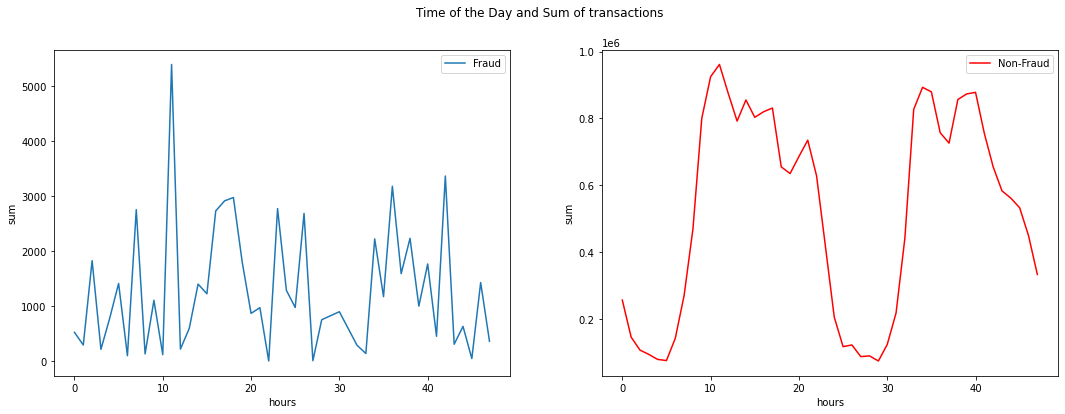

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
plot1 = sns.lineplot(ax=ax1,x='hours',y='sum',data=credit_group.loc[credit_group.Class==1],label='Fraud')
plot2= sns.lineplot(ax=ax2,x='hours',y='sum',data=credit_group.loc[credit_group.Class==0],color='red',label='Non-Fraud')
plt.suptitle('Time of the Day and Sum of transactions')
plt.show()

In [12]:
credit_card_data.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   

        V15       V16       V17       V18       V19       V20       V21  \
0  1.468177 -0.470401  0.207971  0.025791  0.403993  0.251412 -0.018307   
1  0.635558  0.463917 -0.114805 -0.183361 -0.145783 -0.069083 -0.225775   
2  2.345865 -2.890083  1.109969 -0.121359 -2.261857  0.524980  0.247998   
3 -0.631418 -1.059647 -0.684093  1.965775 -1.232622 -0.208038 -0.108300   
4  0.175121 -0.451449 -0.237033 -0.038195  0.803487  0.408542 -0.009431   

        V22       V23       V24       V25       V26       V27       V28  \
0  0.277838 -0.110474  0.066928  0.128539 -0.189115  0.133558 -0.021053   
1 -0.638672  0.101288 -0.339846  0.167170  0.125895 -0.008983  0.014724   
2  0.771679  0.909412 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752   
3  0.005274 -0.190321 -1.175575  0.647376 -0.221929  0.062723  0.061458   
4  0.798278 -0.137458  0.141267 -0.206010  0.502292  0.219422  0.215153   

   Amount  Class  hours  
0  149.62      0      0  
1    2.69      0      0  
2  378.66      0      0  
3  123.50      0      0  
4   69.99      0      0

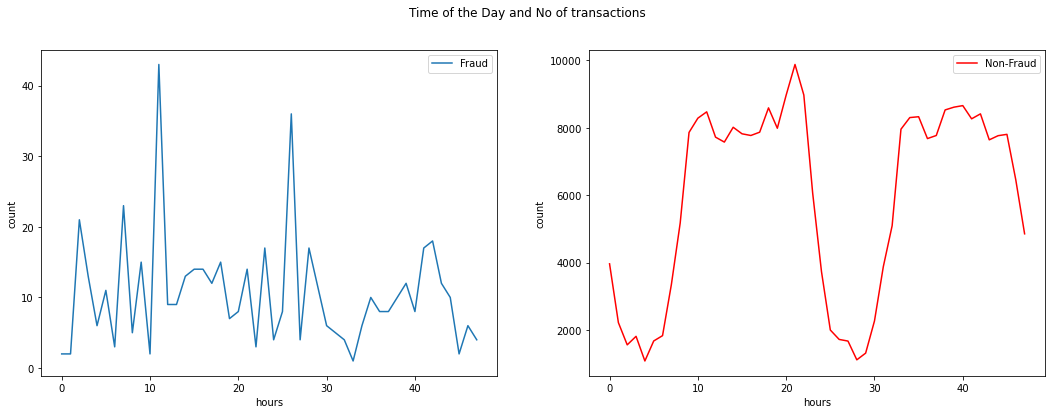

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
plot1 = sns.lineplot(ax=ax1,x='hours',y='count',data=credit_group.loc[credit_group.Class==1],label='Fraud')
plot2= sns.lineplot(ax=ax2,x='hours',y='count',data=credit_group.loc[credit_group.Class==0],color='red',label='Non-Fraud')
plt.suptitle('Time of the Day and No of transactions')
plt.show()

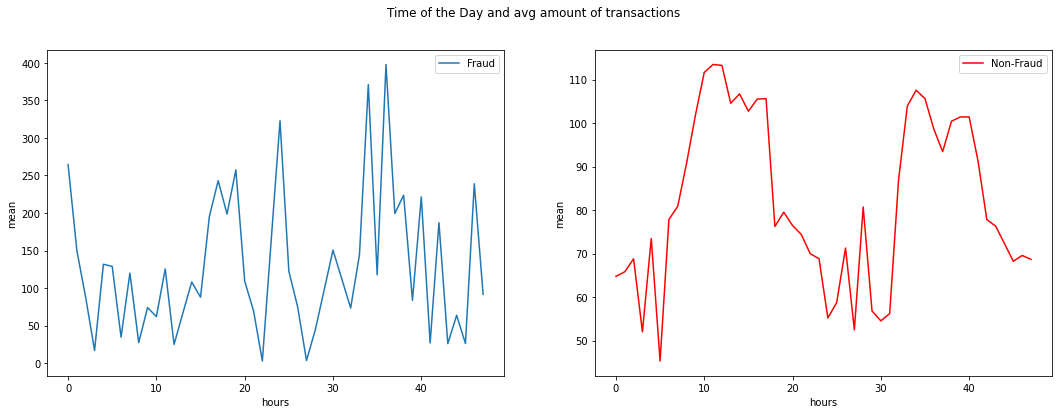

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
plot1 = sns.lineplot(ax=ax1,x='hours',y='mean',data=credit_group.loc[credit_group.Class==1],label='Fraud')
plot2= sns.lineplot(ax=ax2,x='hours',y='mean',data=credit_group.loc[credit_group.Class==0],color='red',label='Non-Fraud')
plt.suptitle('Time of the Day and avg amount of transactions')
plt.show()

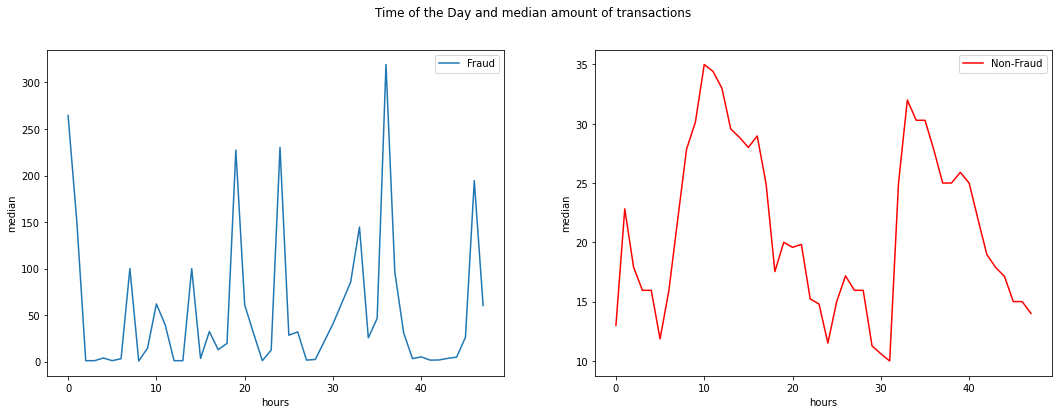

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
plot1 = sns.lineplot(ax=ax1,x='hours',y='median',data=credit_group.loc[credit_group.Class==1],label='Fraud')
plot2= sns.lineplot(ax=ax2,x='hours',y='median',data=credit_group.loc[credit_group.Class==0],color='red',label='Non-Fraud')
plt.suptitle('Time of the Day and median amount of transactions')
plt.show()

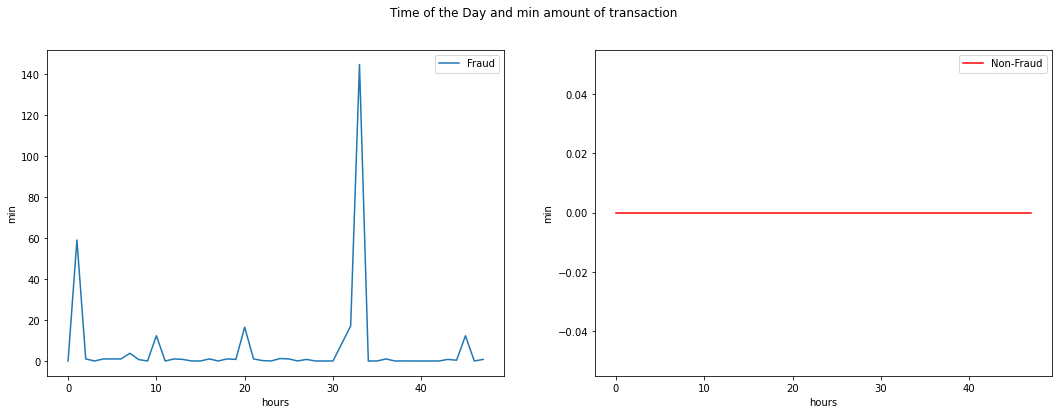

In [16]:
fig, axes = plt.subplots(1,2, figsize=(18,6))
plot1 = sns.lineplot(ax=axes[0],x='hours',y='min',data=credit_group.loc[credit_group.Class==1],label='Fraud')
plot2= sns.lineplot(ax=axes[1],x='hours',y='min',data=credit_group.loc[credit_group.Class==0],color='red',label='Non-Fraud')
plt.suptitle('Time of the Day and min amount of transaction')
plt.show()

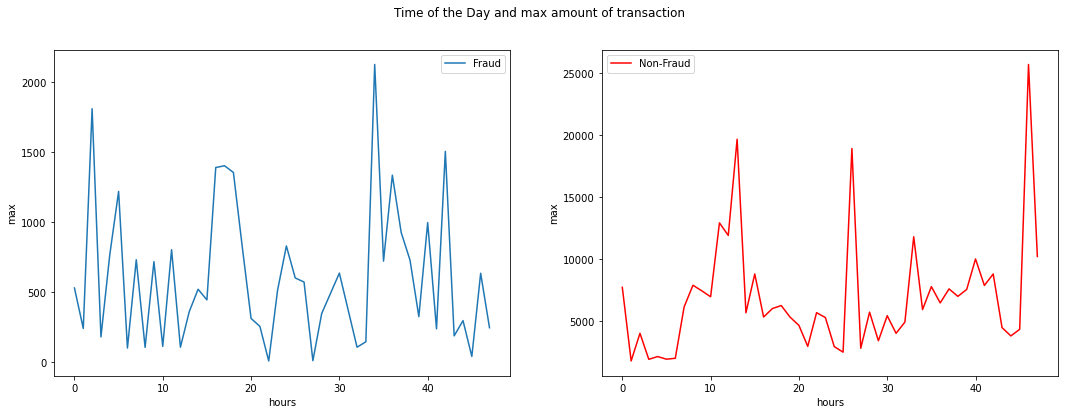

In [17]:
fig, axes = plt.subplots(1,2, figsize=(18,6))
plot1 = sns.lineplot(ax=axes[0],x='hours',y='max',data=credit_group.loc[credit_group.Class==1],label='Fraud')
plot2= sns.lineplot(ax=axes[1],x='hours',y='max',data=credit_group.loc[credit_group.Class==0],color='red',label='Non-Fraud')
plt.suptitle('Time of the Day and max amount of transaction')
plt.show()

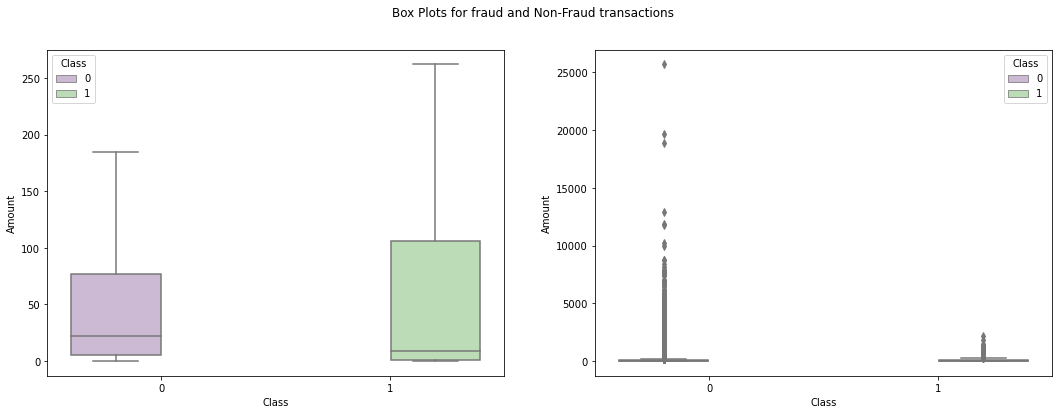

In [18]:
fig, axes = plt.subplots(1,2, figsize=(18,6))
plot1 = sns.boxplot(ax=axes[0],x='Class',y='Amount',data=credit_card_data,hue='Class',palette="PRGn",showfliers=False)
plot2 = sns.boxplot(ax=axes[1],x='Class',y='Amount',data=credit_card_data,hue='Class',palette="PRGn",showfliers=True)
plt.suptitle('Box Plots for fraud and Non-Fraud transactions')
plt.show()

In [19]:
fig =  px.scatter(data_frame=credit_card_data.loc[credit_card_data.Class==1],x='Time',y='Amount',title='Amount of Fraudulent Transactions')

fig.show()

### HeatMap for checking the correlation between features

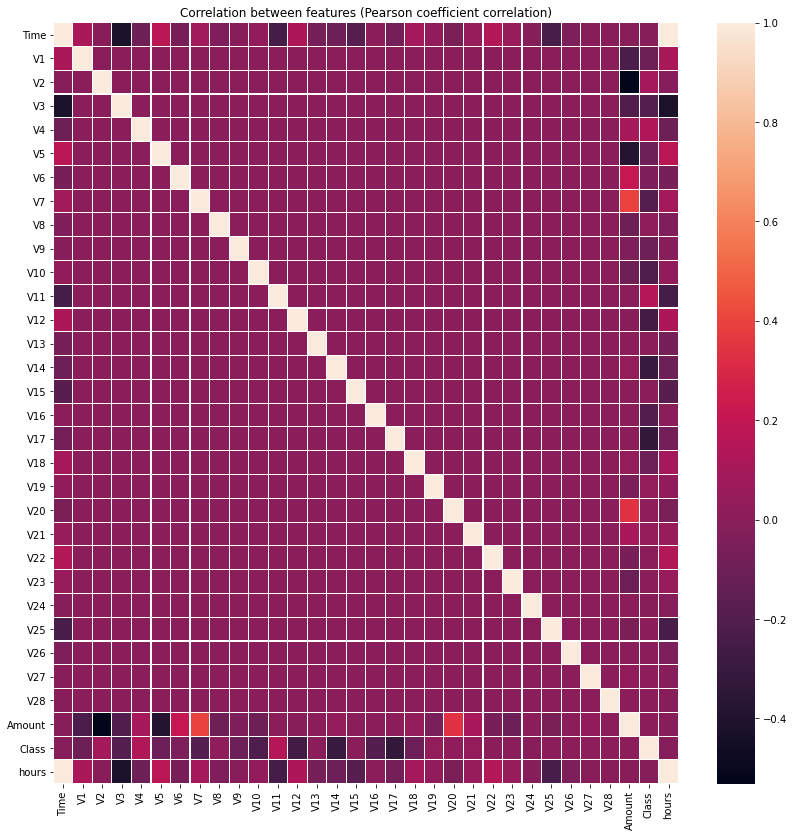

In [20]:
plt.figure(figsize = (14,14))
df_corr = credit_card_data.corr()
sns.heatmap(df_corr,  xticklabels=df_corr.columns,yticklabels=df_corr.columns,linewidths=.1)
plt.title("Correlation between features (Pearson coefficient correlation)")
plt.show()

#### Here we can see there is correlation between features Time and hours which is expected as hours is derived from time. 

#### Also there is inverse correlation between Time and featureas(V3,V11) and also amount with (V5, V2).
#### We observe direct correlation between Amount with (V20 and V7 )

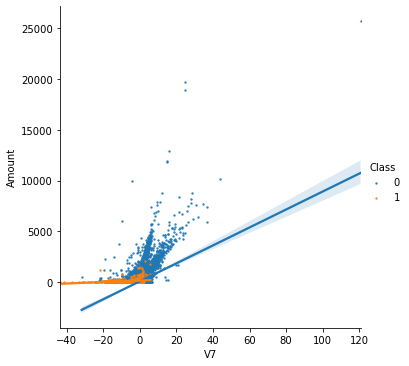

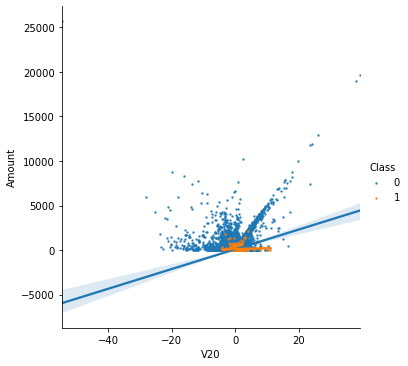

In [21]:
lplot = sns.lmplot(x='V7',y='Amount',data=credit_card_data,hue='Class',fit_reg=True,scatter_kws={'s':2})
lplot = sns.lmplot(x='V20',y='Amount',data=credit_card_data,hue='Class',fit_reg=True,scatter_kws={'s':2})

#### There is definitely correlation between features as  positive slope for Class 0 while regression line for Class = 1 is smaller slope closer to 0

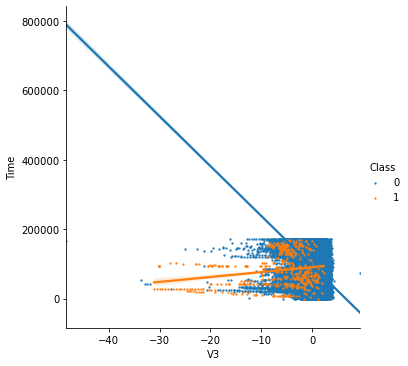

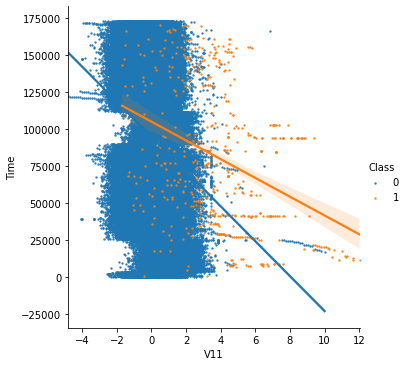

In [22]:
lplot = sns.lmplot(x='V3',y='Time',data=credit_card_data,hue='Class',fit_reg=True,scatter_kws={'s':2})
lplot = sns.lmplot(x='V11',y='Time',data=credit_card_data,hue='Class',fit_reg=True,scatter_kws={'s':2})

#### There is also negative correlation between features V3 as Class=0 has negative slope class regression line for Class = 1 slope is closer to 0

### Kernel Density Plots

<Figure size 432x288 with 0 Axes>

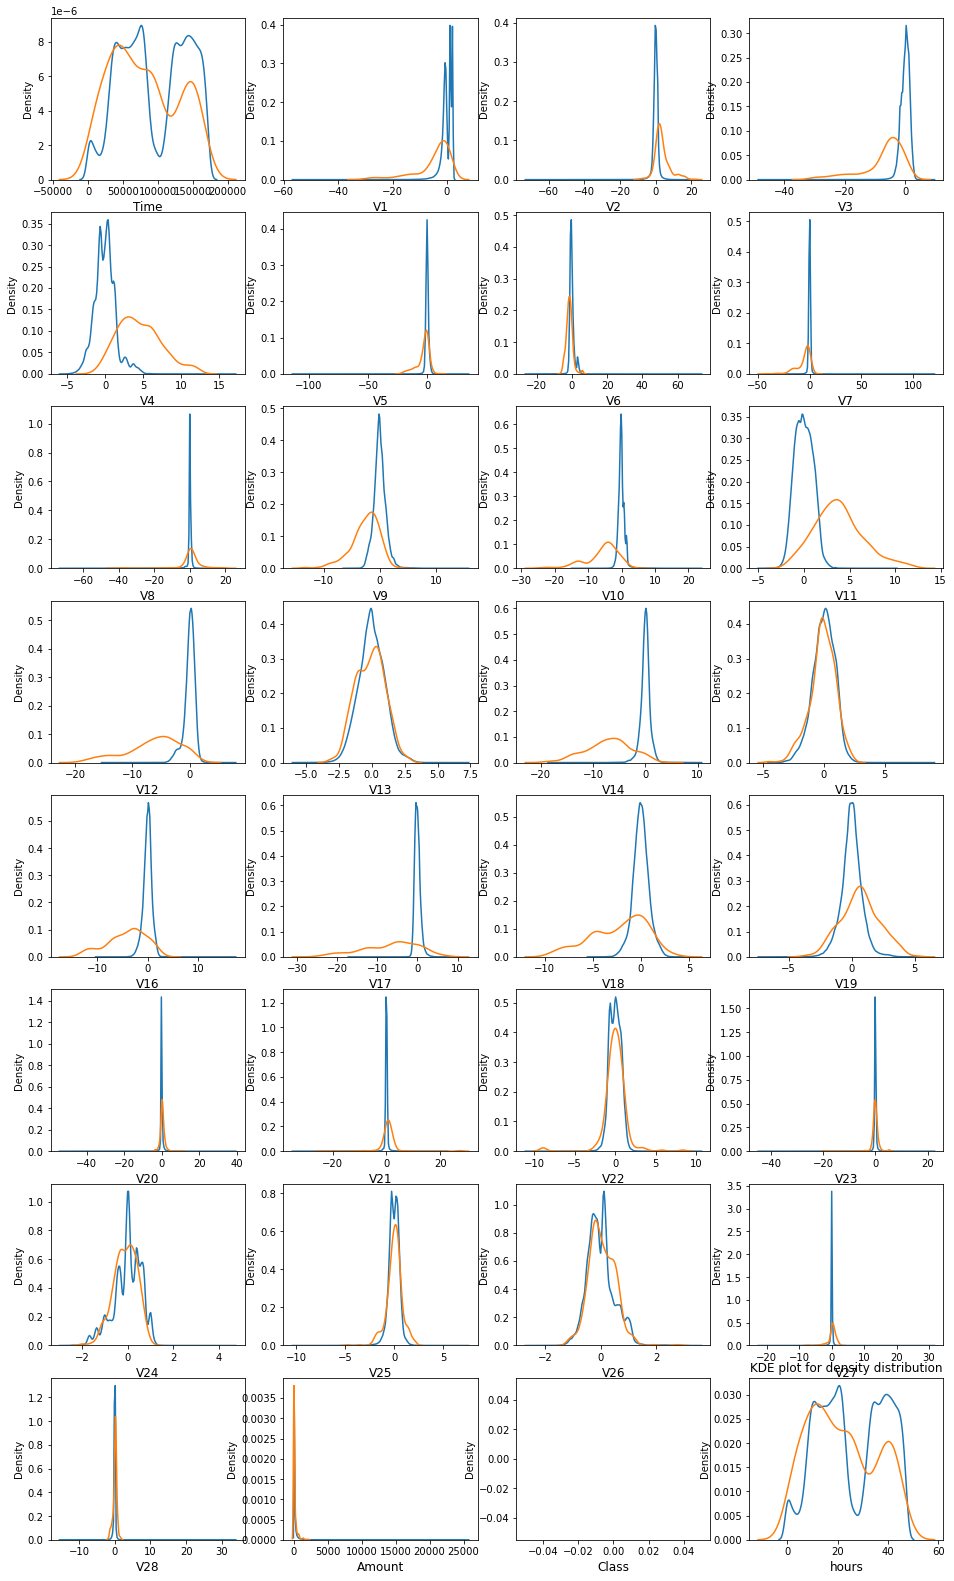

In [23]:
import warnings
warnings.filterwarnings('ignore')
features = credit_card_data.columns.values

class_0 = credit_card_data.loc[credit_card_data.Class==0]
class_1 = credit_card_data.loc[credit_card_data.Class==1]
c=1

plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in features:
    plt.subplot(8,4,c)
    sns.kdeplot(class_0[feature],label='Class 0')
    sns.kdeplot(class_1[feature],label='Class 1')
    plt.xlabel(feature, fontsize=12)
    c+=1
plt.title('KDE plot for density distribution')
plt.show()

We observe good selectivity between features V11, V4 where there are separated distributions for both the classes while features like V12,V14 and V16 are partially separated. V25,V26 and V28 features have very similar distributions

All the features other than Amount and Time is centered around 0. We also observe fraudulent transactions have skewed distributions

### Split the Data between Train, Test and Cross-validation datasets

In [72]:
df_class = credit_card_data['Class']
df_data = credit_card_data.drop(columns=['Class'])
df_features_initial, df_features_test, df_class_intial, df_class_test  = train_test_split(df_data, df_class, test_size=TEST_SIZE, random_state=RANDOM_STATE,shuffle=True)
df_features_train, df_features_cv, df_class_train, df_class_cv = train_test_split(df_features_initial, df_class_intial, test_size=CV_SIZE, random_state=RANDOM_STATE,shuffle=True)

### Define Baseline Model to validate other models

### Random Forest Model

In [26]:
model = RandomForestClassifier()
model.fit(df_features_train,df_class_train)df_class_predict = model.predict(df_features_test)
score = accuracy_score(df_class_test,df_class_predict)
score

0.9995084442259752

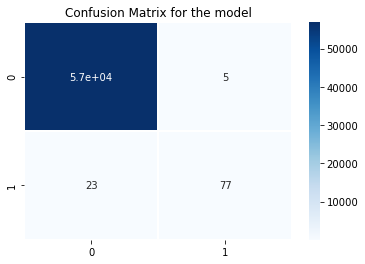

In [27]:
sns.heatmap(confusion_matrix(df_class_test,df_class_predict),annot=True,cmap='Blues',linewidths=0.5)
plt.title('Confusion Matrix for the model')
plt.show()

Confusion Matrix is not a great resource for representing the results of highly imbalanced data as we need different metrics that accounts for selectivity and specificity of the method we are using, so that we minimize in the same time Type 1 and Type 2 errors


<b>Null Hypothesis</b>: Transactions is not fraud<br>
<b>Alternative Hypothesis</b>: Transactions is fraud
    
<b>Type 1 error</b>: You reject Null hypothesis when it is actually true.<br>
<b>Type 2 error</b>: You fail to reject Null hypothesis when alternative hypothesis is true

<b>Cost of Type 1 error</b>: Transaction is errorenously marked as Fraud when it is not<br>
<b>Cost of Type 2 error</b>: Transaction is not marked as Fraud even though it is a fraud transaction

Good resource: https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/

<b>Type 1 and Type 2 errors:</b>

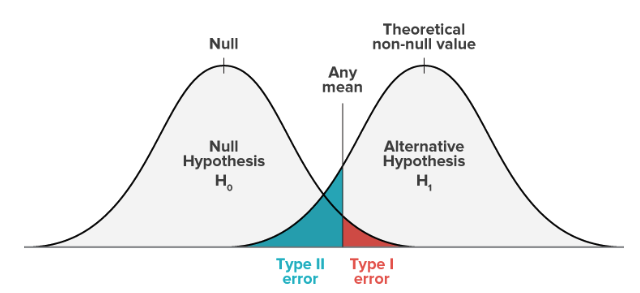

In [103]:
print("Precision Score is {}".format(precision_score(df_class_test.values,df_class_predict)))
print("Recall Score is {}".format(recall_score(df_class_test.values,df_class_predict)))
print("F1 Score is {}".format(f1_score(df_class_test.values,df_class_predict)))

Precision Score is 0.9390243902439024
Recall Score is 0.77
F1 Score is 0.8461538461538461


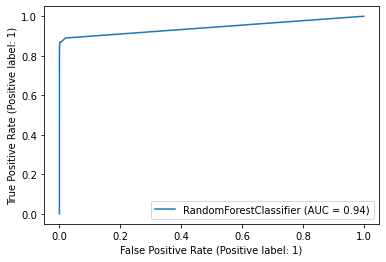

In [37]:
plot_roc_curve(model, df_features_test, df_class_test)
plt.show()

### Feature Importance for Random Forest Model

In [63]:
feature_imp_scores = pd.DataFrame({'col_names': model.feature_names_in_,'feature_scores':model.feature_importances_} )
feature_imp_scores=feature_imp_scores.sort_values(by='feature_scores',ascending=False)
fig = px.bar(feature_imp_scores, x='col_names', y='feature_scores',title='Feature Importance for RF model')
fig.update_xaxes(tickangle=45, tickfont=dict(family='Rockwell', color='black', size=12))
fig.show()

### Training Boosting classifiers on the data

In [96]:
model2 = CatBoostClassifier(iterations=200,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='Recall',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

model2.fit(df_features_train, df_class_train.values,verbose=True)

0:	learn: 0.4827586	total: 167ms	remaining: 33.3s
50:	learn: 0.8379310	total: 8.69s	remaining: 25.4s
100:	learn: 0.8758621	total: 16.7s	remaining: 16.4s
150:	learn: 0.8758621	total: 24.8s	remaining: 8.05s
199:	learn: 0.8862069	total: 32.8s	remaining: 0us


In [97]:
df_predict_test2=model2.predict(df_features_test)

In [98]:
print("Precision Score is {}".format(precision_score(df_class_test.values,df_predict_test2)))
print("Recall Score is {}".format(recall_score(df_class_test.values,df_predict_test2)))
print("F1 Score is {}".format(float(f1_score(df_class_test.values,df_predict_test2)),'%0.2f'))

Precision Score is 0.95
Recall Score is 0.76
F1 Score is 0.8444444444444444


0.7831270444233407


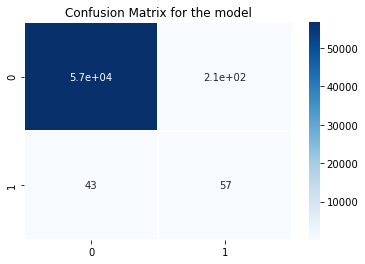

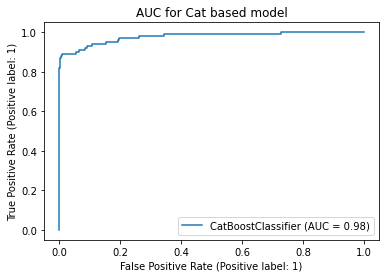

In [153]:
print(roc_auc_score(df_class_test.values,df_predict_test2))
sns.heatmap(confusion_matrix(df_class_test.values,df_predict_test2),annot=True,cmap='Blues',linewidths=0.5)
plt.title('Confusion Matrix for the model')
plot_roc_curve(model2, df_features_test, df_class_test)
plt.title('AUC for Cat based model')
plt.show()

In [157]:
feature_imp_scores = pd.DataFrame({'col_names': model2.feature_names_,'feature_scores':model2.feature_importances_} )
feature_imp_scores=feature_imp_scores.sort_values(by='feature_scores',ascending=False)
fig = px.bar(feature_imp_scores, x='col_names', y='feature_scores',title='Feature Importance for Cat Boost model')
fig.update_xaxes(tickangle=45, tickfont=dict(family='Rockwell', color='black', size=12))
fig.show()

### Xgboost trained on the model

In [106]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(df_features_train, df_class_train.values)
dcv = xgb.DMatrix(df_features_cv, df_class_cv.values)
dtest = xgb.DMatrix(df_features_test, df_class_test.values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dcv, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'recall'
params['random_state'] = RANDOM_STATE

In [115]:
model3 = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[14:23:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.89296	valid-auc:0.85272
[50]	train-auc:0.93947	valid-auc:0.88201
[100]	train-auc:0.94433	valid-auc:0.89125
[150]	train-auc:0.97700	valid-auc:0.96272
[200]	train-auc:0.98903	valid-auc:0.98240
[250]	train-auc:0.99349	valid-auc:0.98503
[300]	train-auc:0.99566	valid-auc:0.98557
[332]	train-auc:0.99660	valid-auc:0.98540


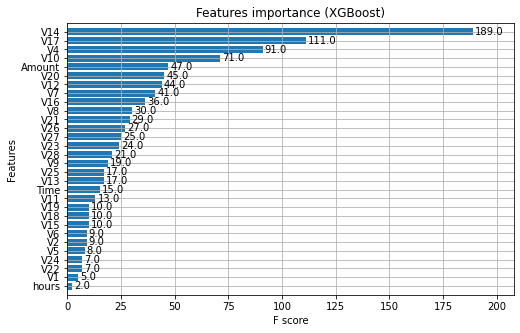

In [117]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax) 
plt.show()

In [124]:
df_predict_test3=model3.predict(dtest)
print("AUC score is {}".format(roc_auc_score(df_class_test.values,df_predict_test3)))

AUC score is 0.9786145404663923


### LightGBM

In [146]:
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(df_features_train, df_class_train)
# predict the results

In [148]:
clf.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [150]:
df_predict_test2=clf.predict(df_features_test)
print("Precision Score is {}".format(precision_score(df_class_test.values,df_predict_test2)))
print("Recall Score is {}".format(recall_score(df_class_test.values,df_predict_test2)))
print("F1 Score is {}".format(float(f1_score(df_class_test.values,df_predict_test2)),'%0.2f'))

Precision Score is 0.2111111111111111
Recall Score is 0.57
F1 Score is 0.30810810810810807


0.7831270444233407


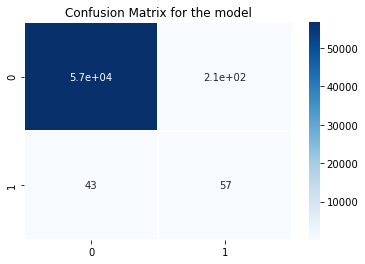

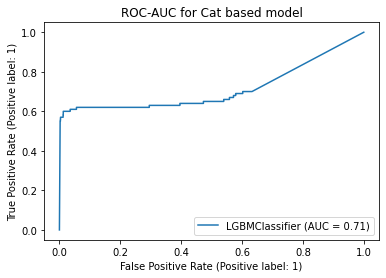

In [152]:
print(roc_auc_score(df_class_test.values,df_predict_test2))
sns.heatmap(confusion_matrix(df_class_test.values,df_predict_test2),annot=True,cmap='Blues',linewidths=0.5)
plt.title('Confusion Matrix for the model')
plot_roc_curve(clf, df_features_test, df_class_test)
plt.title('ROC-AUC for Cat based model')
plt.show()

In [156]:
feature_imp_scores = pd.DataFrame({'col_names': clf.feature_name_,'feature_scores':clf.feature_importances_} )
feature_imp_scores=feature_imp_scores.sort_values(by='feature_scores',ascending=False)
fig = px.bar(feature_imp_scores, x='col_names', y='feature_scores',title='Feature Importance for Light GBM model')
fig.update_xaxes(tickangle=45, tickfont=dict(family='Rockwell', color='black', size=12))
fig.show()

### Conclusion:

We investigated the data, checking for data unbalancing, visualizing the features and understanding the relationship between different features. We then investigated two predictive models. The data was split in 3 parts, a train set, a validation set and a test set.

We started with RandomForrestClassifier, for which we obtained an AUC scode of 0.94 when predicting the target for the test set.

We then followed with an CatBoostClassifier, with the AUC score after training 500 iterations 0.98

We then experimented with a XGBoost model. In this case, se used the validation set for validation of the training model. The best validation score obtained was 0.974.

We then presented the data to a LightGBM model. Here the default prediction results were not satisfactory compared to other modfels.


### Next Steps:

1. Apply Cross-Validation techniques and tune each model using Grid or RandomSearch
2. Apply Deep-Learning techniques to train the model and evaluate the lift in performance
3. Start with a baseline model to compare other model results
4. Explore class-imbalance methods like SMOTE vs updating data to consider weights of class labels